In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
df = pd.read_csv('../data/data_clean.csv')
df.head(5)

/var/folders/nj/s1c8f0tj3ksfjdg8xyxr6rdc0000gn/T/ipykernel_53242/2597316256.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/data_clean.csv')


,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee,acheteur_tranche_effectif,acheteur_categorie,titulaire_tranche_effectif,titulaire_categorie
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215400516.0,78885470100018,SIRET,ACOMETAL,788854701.0,...,45000000,45200000,45260000,45261000,45200000,2024,12,PME,03,PME
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243500667.0,38373211200032,SIRET,UNIVERS,383732112.0,...,71000000,71200000,71200000,71200000,71200000,2021,22,PME,03,PME
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249710047.0,43387249600016,SIRET,COTRAM B.T.P.,433872496.0,...,45000000,45200000,45230000,45232000,45200000,2024,12,PME,12,PME
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625480199.0,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552046955.0,...,50000000,50700000,50720000,50720000,50000000,2024,22,ETI,53,GE
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200025633.0,47698032100238,SIRET,POMONA EPISAVEURS,476980321.0,...,15000000,15800000,15800000,15800000,15000000,2024,12,PME,42,GE


In [3]:
from scripts.data_cleaner import filter_top_cpv_categories

df = filter_top_cpv_categories(df, top_n=150, cpv_column='codeCPV_3')

Filtered from 392 to 150 CPV categories, keeping 279174 rows out of 286850


In [4]:
df.drop(df[df['montant'] > 999999].index, inplace=True)
df.shape

(238163, 38)

In [5]:
y = np.log1p(df['montant'])
y.head()

0    11.292279
1    10.882925
4    13.235694
5    11.350889
6    12.044412
Name: montant, dtype: float64

In [6]:
bins = np.linspace(y.min(), y.max(), 10)

# Créer les étiquettes correspondantes
labels = list(range(1, len(bins)))

# Ajouter la colonne fourchette_de_prix
df['bins'] = pd.cut(y, bins=bins, labels=labels, include_lowest=True, right=True)

df.shape

(238163, 39)

In [52]:
np.exp(bins)

array([  20001.        ,   30890.41494143,   47708.50133762,
         73683.08597334,  113799.36502582,  175756.69245133,
        271446.28561345,  419233.45817256,  647482.39989405,
       1000000.        ])

In [7]:
df['bins'].isna().sum()

0

In [8]:
df['bins'] = df['bins'].astype('int')

In [9]:
df['bins'].unique

<bound method Series.unique of 0         4
1         3
4         8
5         4
6         5
         ..
286844    3
286845    5
286846    2
286848    9
286849    2
Name: bins, Length: 238163, dtype: int64>

In [10]:
df = df.drop(columns='montant')
df.columns

Index(['uid', 'id', 'nature', 'acheteur_id', 'acheteur_nom', 'acheteur_siren',
       'titulaire_id', 'titulaire_typeIdentifiant', 'titulaire_nom',
       'titulaire_siren', 'objet', 'codeCPV', 'procedure', 'dureeMois',
       'dateNotification', 'datePublicationDonnees', 'formePrix',
       'attributionAvance', 'offresRecues', 'marcheInnovant', 'ccag',
       'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance',
       'origineUE', 'origineFrance', 'lieuExecution_code',
       'lieuExecution_typeCode', 'idAccordCadre', 'source_open_data',
       'codeCPV_FR', 'codeCPV_2', 'codeCPV_3', 'codeCPV_4', 'codeCPV_5',
       'codeCPV_2_3', 'annee', 'bins'],
      dtype='object')

In [11]:
X = df.drop(columns='bins')
y = df['bins']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X['codeCPV_3'])

In [13]:
from scripts.preprocess_pipeline import create_pipeline_cat

cat_list = ['marche_sim', 'pred_montant', 'anomalie']
cat = cat_list[1]
pipeline = create_pipeline_cat(cat)

In [14]:
X_train_preproc = pipeline.fit_transform(X_train)

In [34]:
X_train_preproc.shape

(190530, 184)

In [37]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)

(array([[190530.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.],
        [185472.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,   5058.],
        [173323.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  17207.],
        [159638.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  30892.],
        [157710.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  32820.],
        [161973.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  28557.],
        [163929.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  26601.],
        [169780.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  20750.],
        [173854.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  16676.],
        [178561.,  

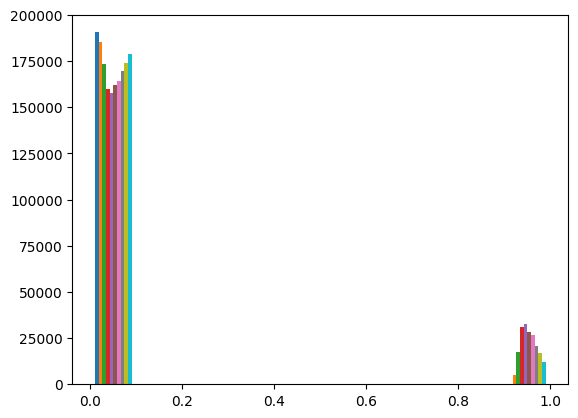

In [54]:
plt.hist(y_train_cat)

In [17]:
#Création du model --> couches Dense

In [50]:
# Modèle
model = Sequential()

# Entrée
model.add(layers.Input(shape=(184,)))

# Couches cachées
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Couche de sortie : 10 classes
model.add(layers.Dense(10, activation='softmax'))

# Compilation du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # ou 'sparse_categorical_crossentropy' si tes labels sont des entiers
    metrics=['accuracy',]
)

# Affichage du résumé
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 512)            │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,818 (1.01 MB)

 Trainable params: 262,026 (1023.54 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [31]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy', 'precision', 'recall'])

In [51]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
        X_train_preproc, y_train_cat,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        callbacks=[es],
        verbose=1)

Epoch 1/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.1801 - loss: 2.2038 - val_accuracy: 0.2090 - val_loss: 1.9679
Epoch 2/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2061 - loss: 1.9778 - val_accuracy: 0.2172 - val_loss: 1.9568
Epoch 3/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2117 - loss: 1.9656 - val_accuracy: 0.2231 - val_loss: 1.9489
Epoch 4/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2169 - loss: 1.9549 - val_accuracy: 0.2243 - val_loss: 1.9429
Epoch 5/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2238 - loss: 1.9443 - val_accuracy: 0.2215 - val_loss: 1.9355
Epoch 6/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2245 - loss: 1.9371 - val_accuracy: 0.2303 - val_loss: 1.9305
Epoch 7/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2277 - loss: 1.9293 - val_accuracy: 0.2294 - val_loss: 1.9282
Epoch 8/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2328 - los

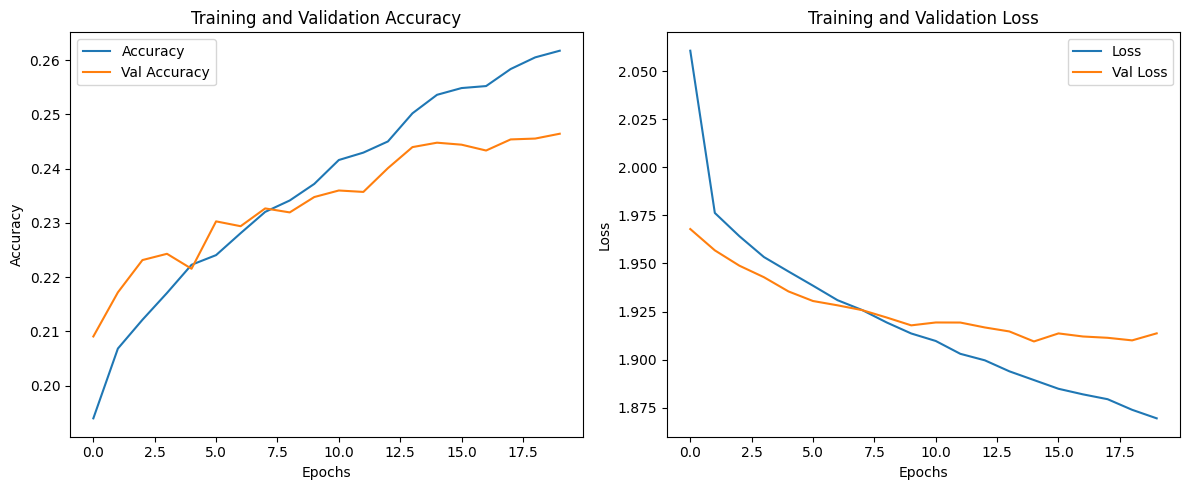

In [53]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()